This notebook was inspired by this blog post: https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/
The Poisson model essentially follows the initial part of above blog. The rest of the notebook applies the results to estimating Fantasy Premier League Assistant Manager chip expected points for each manager. 

In [31]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import requests

from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Fetch data

In [2]:
matches24_25 = pd.read_html('https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures')[0]
matches23_24 = pd.read_html('https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures')[0]
fixtures_fbref = pd.concat([matches23_24, matches24_25], ignore_index=True)
fixtures_fbref['Date'] = pd.to_datetime(fixtures_fbref['Date'])
display(fixtures_fbref)

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN
1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN
2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN
3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN
4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,38.0,Sun,2025-05-25,16:00,Fulham,NaN,NaN,NaN,Manchester City,NaN,Craven Cottage,NaN,Head-to-Head,NaN
838,38.0,Sun,2025-05-25,16:00,Nott'ham Forest,NaN,NaN,NaN,Chelsea,NaN,The City Ground,NaN,Head-to-Head,NaN
839,38.0,Sun,2025-05-25,16:00,Manchester Utd,NaN,NaN,NaN,Aston Villa,NaN,Old Trafford,NaN,Head-to-Head,NaN
840,38.0,Sun,2025-05-25,16:00,Wolves,NaN,NaN,NaN,Brentford,NaN,Molineux Stadium,NaN,Head-to-Head,NaN


In [3]:
results = fixtures_fbref[fixtures_fbref['Score'].notnull()]
results = results.reset_index()
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN
3,3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN
4,4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,680,24.0,Sat,2025-02-01,17:30,Wolves,1.6,2–0,0.4,Aston Villa,31385.0,Molineux Stadium,Andy Madley,Match Report,NaN
615,681,24.0,Sun,2025-02-02,14:00,Brentford,2.1,0–2,0.8,Tottenham,17154.0,Gtech Community Stadium,Jarred Gillett,Match Report,NaN
616,682,24.0,Sun,2025-02-02,14:00,Manchester Utd,1.1,0–2,2.6,Crystal Palace,73751.0,Old Trafford,John Brooks,Match Report,NaN
617,683,24.0,Sun,2025-02-02,16:30,Arsenal,1.0,5–1,0.8,Manchester City,60355.0,Emirates Stadium,Peter Bankes,Match Report,NaN


# Process data

In [4]:
results['home_goals'] = results['Score'].apply(lambda x: x.split('–')[0])
results['away_goals'] = results['Score'].apply(lambda x: x.split('–')[1])
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_goals,away_goals
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN,0,3
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN,2,1
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN,0,1
3,3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN,0,1
4,4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,680,24.0,Sat,2025-02-01,17:30,Wolves,1.6,2–0,0.4,Aston Villa,31385.0,Molineux Stadium,Andy Madley,Match Report,NaN,2,0
615,681,24.0,Sun,2025-02-02,14:00,Brentford,2.1,0–2,0.8,Tottenham,17154.0,Gtech Community Stadium,Jarred Gillett,Match Report,NaN,0,2
616,682,24.0,Sun,2025-02-02,14:00,Manchester Utd,1.1,0–2,2.6,Crystal Palace,73751.0,Old Trafford,John Brooks,Match Report,NaN,0,2
617,683,24.0,Sun,2025-02-02,16:30,Arsenal,1.0,5–1,0.8,Manchester City,60355.0,Emirates Stadium,Peter Bankes,Match Report,NaN,5,1


In [5]:
current_date = dt.datetime.today()
results['days_since'] = results['Date'].apply(lambda x: (current_date-x).days)
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_goals,away_goals,days_since
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN,0,3,550
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN,2,1,549
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN,0,1,549
3,3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN,0,1,549
4,4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN,4,1,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,680,24.0,Sat,2025-02-01,17:30,Wolves,1.6,2–0,0.4,Aston Villa,31385.0,Molineux Stadium,Andy Madley,Match Report,NaN,2,0,10
615,681,24.0,Sun,2025-02-02,14:00,Brentford,2.1,0–2,0.8,Tottenham,17154.0,Gtech Community Stadium,Jarred Gillett,Match Report,NaN,0,2,9
616,682,24.0,Sun,2025-02-02,14:00,Manchester Utd,1.1,0–2,2.6,Crystal Palace,73751.0,Old Trafford,John Brooks,Match Report,NaN,0,2,9
617,683,24.0,Sun,2025-02-02,16:30,Arsenal,1.0,5–1,0.8,Manchester City,60355.0,Emirates Stadium,Peter Bankes,Match Report,NaN,5,1,9


In [6]:
results = results[results.days_since < 365]
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_goals,away_goals,days_since
238,263,25.0,Sat,2024-02-17,12:30,Brentford,1.6,1–4,2.8,Liverpool,17193.0,Gtech Community Stadium,Michael Oliver,Match Report,NaN,1,4,360
239,264,25.0,Sat,2024-02-17,15:00,Newcastle Utd,2.2,2–2,2.2,Bournemouth,52224.0,St James' Park,Michael Salisbury,Match Report,NaN,2,2,360
240,265,25.0,Sat,2024-02-17,15:00,Tottenham,1.6,1–2,1.8,Wolves,61532.0,Tottenham Hotspur Stadium,Anthony Taylor,Match Report,NaN,1,2,360
241,266,25.0,Sat,2024-02-17,15:00,Burnley,0.3,0–5,2.3,Arsenal,21311.0,Turf Moor,Jarred Gillett,Match Report,NaN,0,5,360
242,267,25.0,Sat,2024-02-17,15:00,Fulham,1.5,1–2,1.5,Aston Villa,24401.0,Craven Cottage,Lewis Smith,Match Report,NaN,1,2,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,680,24.0,Sat,2025-02-01,17:30,Wolves,1.6,2–0,0.4,Aston Villa,31385.0,Molineux Stadium,Andy Madley,Match Report,NaN,2,0,10
615,681,24.0,Sun,2025-02-02,14:00,Brentford,2.1,0–2,0.8,Tottenham,17154.0,Gtech Community Stadium,Jarred Gillett,Match Report,NaN,0,2,9
616,682,24.0,Sun,2025-02-02,14:00,Manchester Utd,1.1,0–2,2.6,Crystal Palace,73751.0,Old Trafford,John Brooks,Match Report,NaN,0,2,9
617,683,24.0,Sun,2025-02-02,16:30,Arsenal,1.0,5–1,0.8,Manchester City,60355.0,Emirates Stadium,Peter Bankes,Match Report,NaN,5,1,9


# Model

In [7]:
goal_model_data = pd.concat([results[['Home','Away','home_goals']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','home_goals':'goals'}),
           results[['Away','Home','away_goals']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','away_goals':'goals'})]).reset_index(drop=True)

goal_model_data['goals'] = goal_model_data['goals'].apply(lambda x: int(x))

goal_model_data

,team,opponent,goals,home
0,Brentford,Liverpool,1,1
1,Newcastle Utd,Bournemouth,2,1
2,Tottenham,Wolves,1,1
3,Burnley,Arsenal,0,1
4,Fulham,Aston Villa,1,1
...,...,...,...,...
757,Aston Villa,Wolves,0,0
758,Tottenham,Brentford,2,0
759,Crystal Palace,Manchester Utd,2,0
760,Manchester City,Arsenal,1,0


In [8]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  762
Model:                            GLM   Df Residuals:                      716
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1120.6
Date:                Tue, 11 Feb 2025   Deviance:                       746.20
Time:                        21:51:33   Pearson chi2:                     643.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2182
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [9]:
poisson_model.predict(pd.DataFrame(data={'team': 'Southampton', 'opponent': 'Liverpool', 'home':0},index=[1]))

1    0.51389
dtype: float64

In [10]:
np.exp(0.0913)

np.float64(1.0955976352520773)

# Predict fixtures

In [11]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [12]:
fixtures = fixtures_fbref[(fixtures_fbref['Score'].isnull()) & (fixtures_fbref['Wk'].notnull())].reset_index()
fixtures

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,686,15.0,Wed,2025-02-12,19:30,Everton,NaN,NaN,NaN,Liverpool,NaN,Goodison Park,NaN,Head-to-Head,NaN
1,688,25.0,Fri,2025-02-14,20:00,Brighton,NaN,NaN,NaN,Chelsea,NaN,The American Express Stadium,NaN,Head-to-Head,NaN
2,689,25.0,Sat,2025-02-15,12:30,Leicester City,NaN,NaN,NaN,Arsenal,NaN,King Power Stadium,NaN,Head-to-Head,NaN
3,690,25.0,Sat,2025-02-15,15:00,Aston Villa,NaN,NaN,NaN,Ipswich Town,NaN,Villa Park,NaN,Head-to-Head,NaN
4,691,25.0,Sat,2025-02-15,15:00,Fulham,NaN,NaN,NaN,Nott'ham Forest,NaN,Craven Cottage,NaN,Head-to-Head,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,837,38.0,Sun,2025-05-25,16:00,Fulham,NaN,NaN,NaN,Manchester City,NaN,Craven Cottage,NaN,Head-to-Head,NaN
137,838,38.0,Sun,2025-05-25,16:00,Nott'ham Forest,NaN,NaN,NaN,Chelsea,NaN,The City Ground,NaN,Head-to-Head,NaN
138,839,38.0,Sun,2025-05-25,16:00,Manchester Utd,NaN,NaN,NaN,Aston Villa,NaN,Old Trafford,NaN,Head-to-Head,NaN
139,840,38.0,Sun,2025-05-25,16:00,Wolves,NaN,NaN,NaN,Brentford,NaN,Molineux Stadium,NaN,Head-to-Head,NaN


In [13]:
i=0
outcome_matrix = simulate_match(poisson_model, fixtures.loc[i, 'Home'], fixtures.loc[i, 'Away'])

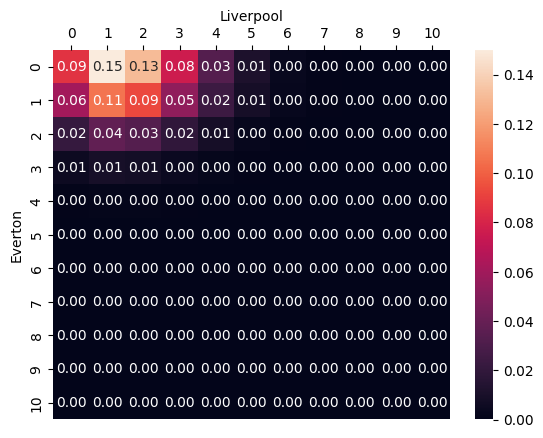

In [14]:
ax = sns.heatmap(outcome_matrix, annot=True, fmt=".2f")
ax.set(xlabel=fixtures.loc[i, 'Away'], ylabel=fixtures.loc[i, 'Home'])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [15]:
poisson_model.predict(pd.DataFrame(data={'team': 'Everton', 'opponent': 'Liverpool', 'home':1},index=[1]))

1    0.708859
dtype: float64

In [16]:
poisson_model.predict(pd.DataFrame(data={'team': 'Liverpool', 'opponent': 'Everton', 'home':0},index=[1]))

1    1.745149
dtype: float64

In [17]:
poisson.pmf(0, 0.704353)*poisson.pmf(1, 1.749606)

np.float64(0.15038322940939658)

In [18]:
outcome_matrix[np.tril_indices_from(outcome_matrix, k=-1)].sum()

np.float64(0.1474453376893061)

In [19]:
np.trace(outcome_matrix)

np.float64(0.2300415777820622)

In [20]:
outcome_matrix[np.triu_indices_from(outcome_matrix, k=1)].sum()

np.float64(0.6225107484857755)

In [21]:
all_probabilities = []
for _, fixture in fixtures.iterrows():
    # probability of different scorelines
    outcome_matrix = simulate_match(poisson_model, fixture['Home'], fixture['Away'])
    # match outcome probabilities
    probability_home_win = outcome_matrix[np.tril_indices_from(outcome_matrix, k=-1)].sum()
    probability_draw = np.trace(outcome_matrix)
    probability_away_win = outcome_matrix[np.triu_indices_from(outcome_matrix, k=1)].sum()
    # add probabilities to list
    all_probabilities.append([probability_home_win, probability_draw, probability_away_win])

# add all probabilites to fixtures df
fixtures[['home_win_probability', 'draw_probability', 'away_win_probability']] = all_probabilities

display(fixtures)

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_win_probability,draw_probability,away_win_probability
0,686,15.0,Wed,2025-02-12,19:30,Everton,NaN,NaN,NaN,Liverpool,NaN,Goodison Park,NaN,Head-to-Head,NaN,0.147445,0.230042,0.622511
1,688,25.0,Fri,2025-02-14,20:00,Brighton,NaN,NaN,NaN,Chelsea,NaN,The American Express Stadium,NaN,Head-to-Head,NaN,0.221770,0.209550,0.568668
2,689,25.0,Sat,2025-02-15,12:30,Leicester City,NaN,NaN,NaN,Arsenal,NaN,King Power Stadium,NaN,Head-to-Head,NaN,0.044504,0.103987,0.851254
3,690,25.0,Sat,2025-02-15,15:00,Aston Villa,NaN,NaN,NaN,Ipswich Town,NaN,Villa Park,NaN,Head-to-Head,NaN,0.642780,0.196288,0.160915
4,691,25.0,Sat,2025-02-15,15:00,Fulham,NaN,NaN,NaN,Nott'ham Forest,NaN,Craven Cottage,NaN,Head-to-Head,NaN,0.367025,0.262719,0.370256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,837,38.0,Sun,2025-05-25,16:00,Fulham,NaN,NaN,NaN,Manchester City,NaN,Craven Cottage,NaN,Head-to-Head,NaN,0.202658,0.215479,0.581855
137,838,38.0,Sun,2025-05-25,16:00,Nott'ham Forest,NaN,NaN,NaN,Chelsea,NaN,The City Ground,NaN,Head-to-Head,NaN,0.311865,0.229375,0.458756
138,839,38.0,Sun,2025-05-25,16:00,Manchester Utd,NaN,NaN,NaN,Aston Villa,NaN,Old Trafford,NaN,Head-to-Head,NaN,0.395552,0.238625,0.365821
139,840,38.0,Sun,2025-05-25,16:00,Wolves,NaN,NaN,NaN,Brentford,NaN,Molineux Stadium,NaN,Head-to-Head,NaN,0.285166,0.219015,0.495811


# FPL Assistant Manager Chip

In [22]:
league_table = pd.read_html('https://fbref.com/en/comps/9/Premier-League-Stats')[0]
league_table

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Liverpool,23,17,5,1,56,21,35,56,2.43,53.9,20.8,33.1,1.44,D D W W W,60289,Mohamed Salah - 21,Alisson,NaN
1,2,Arsenal,24,14,8,2,49,22,27,50,2.08,38.6,21.2,17.4,0.73,D W D W W,60276,Kai Havertz - 9,David Raya,NaN
2,3,Nott'ham Forest,24,14,5,5,40,27,13,47,1.96,31.7,26.7,5.0,0.21,W D W L W,30056,Chris Wood - 17,Matz Sels,NaN
3,4,Chelsea,24,12,7,5,47,31,16,43,1.79,48.6,34.2,14.4,0.60,D D W L W,39608,Cole Palmer - 14,Robert Sánchez,NaN
4,5,Manchester City,24,12,5,7,48,35,13,41,1.71,44.2,34.1,10.0,0.42,W D W W L,52944,Erling Haaland - 19,Ederson,NaN
5,6,Newcastle Utd,24,12,5,7,42,29,13,41,1.71,41.3,29.4,11.9,0.49,W W L W L,52186,Alexander Isak - 17,Nick Pope,NaN
6,7,Bournemouth,24,11,7,6,41,28,13,40,1.67,45.6,31.2,14.4,0.60,W D W W L,11213,Justin Kluivert - 11,Kepa Arrizabalaga,NaN
7,8,Aston Villa,24,10,7,7,34,37,-3,37,1.54,34.2,29.8,4.4,0.18,W W D D L,41878,Ollie Watkins - 10,Emiliano Martínez,NaN
8,9,Fulham,24,9,9,6,36,32,4,36,1.50,33.9,27.6,6.3,0.26,D L W L W,26480,Raúl Jiménez - 9,Bernd Leno,NaN
9,10,Brighton,24,8,10,6,35,38,-3,34,1.42,32.3,36.3,-4.0,-0.17,D W W L L,32398,Danny Welbeck - 6,Bart Verbruggen,NaN


In [23]:
teams = "Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Chelsea,Crystal Palace,Everton,Fulham,Ipswich Town,Leicester City,Liverpool,Manchester City,Manchester Utd,Newcastle Utd,Nott'ham Forest,Southampton,Tottenham,West Ham,Wolves" 
teams = teams.split(',')
teams

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Ipswich Town',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester Utd',
 'Newcastle Utd',
 "Nott'ham Forest",
 'Southampton',
 'Tottenham',
 'West Ham',
 'Wolves']

In [24]:
fpl_fixtures_data = json.loads(requests.get('https://fantasy.premierleague.com/api/fixtures/').text)
fpl_fixtures = pd.DataFrame(fpl_fixtures_data)
fpl_fixtures['home_team'] = [teams[i] for i in fpl_fixtures['team_h']-1]
fpl_fixtures['away_team'] = [teams[i] for i in fpl_fixtures['team_a']-1]
fpl_fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,home_team,away_team
0,2444758,NaN,False,False,289,None,0,True,None,7,NaN,15,NaN,[],3,4,116115,Newcastle Utd,Crystal Palace
1,2444470,1.0,True,True,1,2024-08-16T19:00:00Z,90,False,True,9,0.0,14,1.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,115827,Manchester Utd,Fulham
2,2444473,1.0,True,True,4,2024-08-17T11:30:00Z,90,False,True,12,2.0,10,0.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",5,2,115830,Ipswich Town,Liverpool
3,2444471,1.0,True,True,2,2024-08-17T14:00:00Z,90,False,True,20,0.0,1,2.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,4,115828,Arsenal,Wolves
4,2444472,1.0,True,True,3,2024-08-17T14:00:00Z,90,False,True,5,3.0,8,0.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,3,115829,Everton,Brighton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2444845,38.0,False,False,376,2025-05-25T15:00:00Z,0,False,False,8,NaN,15,NaN,[],2,4,116202,Newcastle Utd,Everton
376,2444846,38.0,False,False,377,2025-05-25T15:00:00Z,0,False,False,6,NaN,16,NaN,[],4,4,116203,Nott'ham Forest,Chelsea
377,2444847,38.0,False,False,378,2025-05-25T15:00:00Z,0,False,False,1,NaN,17,NaN,[],4,2,116204,Southampton,Arsenal
378,2444848,38.0,False,False,379,2025-05-25T15:00:00Z,0,False,False,5,NaN,18,NaN,[],3,3,116205,Tottenham,Brighton


In [25]:
fixtures = fpl_fixtures[fpl_fixtures['team_h_score'].isnull()].reset_index(drop=True)
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,home_team,away_team
0,2444758,NaN,False,False,289,None,0,True,None,7,NaN,15,NaN,[],3,4,116115,Newcastle Utd,Crystal Palace
1,2444613,24.0,False,False,144,2025-02-12T19:30:00Z,0,False,False,12,NaN,8,NaN,[],5,3,115970,Everton,Liverpool
2,2444711,25.0,False,False,242,2025-02-14T20:00:00Z,0,False,False,6,NaN,5,NaN,[],4,3,116068,Brighton,Chelsea
3,2444714,25.0,False,False,245,2025-02-15T12:30:00Z,0,False,False,1,NaN,11,NaN,[],4,2,116071,Leicester City,Arsenal
4,2444710,25.0,False,False,241,2025-02-15T15:00:00Z,0,False,False,10,NaN,2,NaN,[],2,3,116067,Aston Villa,Ipswich Town
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2444845,38.0,False,False,376,2025-05-25T15:00:00Z,0,False,False,8,NaN,15,NaN,[],2,4,116202,Newcastle Utd,Everton
137,2444846,38.0,False,False,377,2025-05-25T15:00:00Z,0,False,False,6,NaN,16,NaN,[],4,4,116203,Nott'ham Forest,Chelsea
138,2444847,38.0,False,False,378,2025-05-25T15:00:00Z,0,False,False,1,NaN,17,NaN,[],4,2,116204,Southampton,Arsenal
139,2444848,38.0,False,False,379,2025-05-25T15:00:00Z,0,False,False,5,NaN,18,NaN,[],3,3,116205,Tottenham,Brighton


In [26]:
all_probabilities = []
for _, fixture in fixtures.iterrows():
    # probability of different scorelines
    outcome_matrix = simulate_match(poisson_model, fixture['home_team'], fixture['away_team'])
    # match outcome probabilities
    probability_home_win = outcome_matrix[np.tril_indices_from(outcome_matrix, k=-1)].sum()
    probability_draw = np.trace(outcome_matrix)
    probability_away_win = outcome_matrix[np.triu_indices_from(outcome_matrix, k=1)].sum()
    # add probabilities to list
    all_probabilities.append([probability_home_win, probability_draw, probability_away_win])

# add all probabilites to fixtures df
fixtures[['home_win_probability', 'draw_probability', 'away_win_probability']] = all_probabilities

fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,...,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,home_team,away_team,home_win_probability,draw_probability,away_win_probability
0,2444758,NaN,False,False,289,None,0,True,None,7,...,NaN,[],3,4,116115,Newcastle Utd,Crystal Palace,0.433745,0.248286,0.317968
1,2444613,24.0,False,False,144,2025-02-12T19:30:00Z,0,False,False,12,...,NaN,[],5,3,115970,Everton,Liverpool,0.147445,0.230042,0.622511
2,2444711,25.0,False,False,242,2025-02-14T20:00:00Z,0,False,False,6,...,NaN,[],4,3,116068,Brighton,Chelsea,0.221770,0.209550,0.568668
3,2444714,25.0,False,False,245,2025-02-15T12:30:00Z,0,False,False,1,...,NaN,[],4,2,116071,Leicester City,Arsenal,0.044504,0.103987,0.851254
4,2444710,25.0,False,False,241,2025-02-15T15:00:00Z,0,False,False,10,...,NaN,[],2,3,116067,Aston Villa,Ipswich Town,0.642780,0.196288,0.160915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2444845,38.0,False,False,376,2025-05-25T15:00:00Z,0,False,False,8,...,NaN,[],2,4,116202,Newcastle Utd,Everton,0.569025,0.243030,0.187943
137,2444846,38.0,False,False,377,2025-05-25T15:00:00Z,0,False,False,6,...,NaN,[],4,4,116203,Nott'ham Forest,Chelsea,0.311865,0.229375,0.458756
138,2444847,38.0,False,False,378,2025-05-25T15:00:00Z,0,False,False,1,...,NaN,[],4,2,116204,Southampton,Arsenal,0.028125,0.089280,0.882332
139,2444848,38.0,False,False,379,2025-05-25T15:00:00Z,0,False,False,5,...,NaN,[],3,3,116205,Tottenham,Brighton,0.533012,0.220405,0.246577


In [27]:
def table_bonus_check(focal_team, opponent):
    focal_team_rank = league_table.loc[league_table.Squad==focal_team, 'Rk'].values[0]
    opponent_rank = league_table.loc[league_table.Squad==opponent, 'Rk'].values[0]
    if focal_team_rank - opponent_rank >= 5:
        return 1.0
    else:
        return 0.0

In [28]:
manager_xp = []
for _, row in fixtures.iterrows():
    if np.isnan(row.event):
        continue
    else:
        # calculate expected goals for both teams
        home_team_xg = poisson_model.predict(pd.DataFrame(data={'team': row.home_team, 'opponent': row.away_team, 'home':1},index=[1])).values[0]
        away_team_xg = poisson_model.predict(pd.DataFrame(data={'team': row.away_team, 'opponent': row.home_team, 'home':0},index=[1])).values[0]
        
        # CALCULATE EXPECTED MANAGER POINTS FOR HOME TEAM
        new_row1 = [row.event, row.home_team, 0]
        table_bonus_coefficient = table_bonus_check(row.home_team, row.away_team) # 1 or 0
        # points for win
        new_row1[2] += 6*row.home_win_probability + 10*table_bonus_coefficient
        # points for draw
        new_row1[2] += 3*row.draw_probability + 5*table_bonus_coefficient
        # expected goals scored
        new_row1[2] += home_team_xg
        # points for clean sheet
        new_row1[2] += poisson.pmf(0, away_team_xg)

        # CALCULATE EXPECTED MANAGER POINTS FOR AWAY TEAM
        new_row2 = [row.event, row.away_team, 0]
        table_bonus_coefficient = table_bonus_check(row.away_team, row.home_team) # 1 or 0
        # points for win
        new_row2[2] += 6*row.away_win_probability + 10*table_bonus_coefficient
        # points for draw
        new_row2[2] += 3*row.draw_probability + 5*table_bonus_coefficient
        # expected goals scored
        new_row2[2] += away_team_xg
        # points for clean sheet
        new_row2[2] += poisson.pmf(0, home_team_xg)

        # add rows to manager_xp
        manager_xp.extend([new_row1, new_row2])
        
manager_df = pd.DataFrame(manager_xp, columns=['gameweek', 'team', 'expected_points'])
manager_df

,gameweek,team,expected_points
0,24.0,Everton,17.458275
1,24.0,Liverpool,6.662544
2,25.0,Brighton,18.319528
3,25.0,Chelsea,6.414253
4,25.0,Leicester City,16.193305
...,...,...,...
275,38.0,Arsenal,9.197103
276,38.0,Tottenham,6.085708
277,38.0,Brighton,3.544368
278,38.0,Wolves,18.956068


In [29]:
weekly_scores = manager_df.groupby(['gameweek', 'team']).sum().reset_index()
weekly_scores

,gameweek,team,expected_points
0,24.0,Everton,17.458275
1,24.0,Liverpool,6.662544
2,25.0,Arsenal,8.939772
3,25.0,Aston Villa,24.894871
4,25.0,Bournemouth,7.575945
...,...,...,...
273,38.0,Nott'ham Forest,4.169123
274,38.0,Southampton,15.884658
275,38.0,Tottenham,6.085708
276,38.0,West Ham,5.714851


In [37]:
fig = px.line(weekly_scores, x='gameweek', y='expected_points', color='team', markers=True,
              title="Expected Points per Game Week",
              labels={"expected_points": "Expected Points", "gameweek": "Game Week"})

fig.show()

In [41]:
# Get unique teams
teams = np.sort(weekly_scores['team'].unique())
default_team = teams[0]  # Default highlighted team

# Create figure
fig = go.Figure()

for team in teams:
    fig.add_trace(go.Scatter(
        x=weekly_scores[weekly_scores['team'] == team]['gameweek'],
        y=weekly_scores[weekly_scores['team'] == team]['expected_points'],
        mode='lines+markers',
        name=team,
        line=dict(color='blue' if team == default_team else 'gray'),
        opacity=1 if team == default_team else 0.3,
        visible=True
    ))

# Create dropdown menu
dropdown_buttons = []
for selected_team in teams:
    button = {
        "label": selected_team,
        "method": "update",
        "args": [
            {
                "opacity": [1 if team == selected_team else 0.3 for team in teams],
                "line": [dict(color="blue" if team == selected_team else "gray") for team in teams],
            },
            {"title": f"Expected Points per Game Week - {selected_team}"}
        ]
    }
    dropdown_buttons.append(button)

# Add dropdown menu
fig.update_layout(
    title=f"Expected Points per Game Week - {default_team}",
    xaxis_title="Game Week",
    yaxis_title="Expected Points",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
    }]
)

fig.show()

In [81]:
weekly_scores['3_week_rolling_sum_xp'] = weekly_scores.groupby("team")["expected_points"].rolling(3).sum().reset_index(level=0, drop=True)
weekly_scores

,gameweek,team,expected_points,3_week_rolling_sum_xp
0,24.0,Everton,17.458275,NaN
1,24.0,Liverpool,6.662544,NaN
2,25.0,Arsenal,8.939772,NaN
3,25.0,Aston Villa,24.894871,NaN
4,25.0,Bournemouth,7.575945,NaN
...,...,...,...,...
273,38.0,Nott'ham Forest,4.169123,17.172270
274,38.0,Southampton,15.884658,34.607148
275,38.0,Tottenham,6.085708,31.181408
276,38.0,West Ham,5.714851,28.412063


In [82]:
# Get unique teams
teams = np.sort(weekly_scores['team'].unique())
default_team = teams[0]  # Default highlighted team

# Create figure
fig = go.Figure()

for team in teams:
    fig.add_trace(go.Scatter(
        x=weekly_scores[weekly_scores['team'] == team]['gameweek'],
        y=weekly_scores[weekly_scores['team'] == team]['3_week_rolling_sum_xp'],
        mode='lines+markers',
        name=team,
        line=dict(color='blue' if team == default_team else 'gray'),
        opacity=1 if team == default_team else 0.3,
        visible=True
    ))

# Create dropdown menu
dropdown_buttons = []
for selected_team in teams:
    button = {
        "label": selected_team,
        "method": "update",
        "args": [
            {
                "opacity": [1 if team == selected_team else 0.3 for team in teams],
                "line": [dict(color="blue" if team == selected_team else "gray") for team in teams],
            },
            {"title": f"3-week Rolling Sum of Expected Points - {selected_team}"}
        ]
    }
    dropdown_buttons.append(button)

# Add dropdown menu
fig.update_layout(
    title=f"3-week Rolling Sum of Expected Points - {default_team}",
    xaxis_title="Gameweek",
    yaxis_title="Expected Points",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
    }]
)

fig.show()